# Basic Queries and Histograms on numerical datasets

First off, we are going to test the applicability of the already given IBM diffprivlib mechanisms on a numerical dataset. Our goal is to run basic queries, such as mean value, sum and max elements on the datast's records. We are also going to present several histograms, regarding the data given. We are going to do that first by applying no DP at all, and then by applying different kinds of noises generated by a plethora of mechanisms to the data. 

## The identity of the dataset: Surgery Charges Across the U.S.

The dataset contains different kinds of surgeries in a plethora of different hospitals. The information gathered by those cobinations, are the average charges of the surgery, which is going to help a potential patient balance his need of top care, and the need to spend less money.

The columns contained are: 
 - __Surgery code and definition__ 
 - __Provider hospital name__
 - __Provider city__
 - __Provider state code__
 - __Average total payments__
 - __Average medicare payments__

## Import libraries

In [2]:
import pandas as pd
import diffprivlib as dp
import numpy as np
import matplotlib.pyplot as plt

## Load the dataset

In [3]:
DATASET = "./surgeries.csv"
df = pd.read_csv(DATASET)

Let's take a look at the dataset info to see if everything is alright.


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202655 entries, 0 to 202654
Data columns (total 6 columns):
 #   Column                     Non-Null Count   Dtype 
---  ------                     --------------   ----- 
 0   Surgery Type               202655 non-null  object
 1   Hospital name              202655 non-null  object
 2   Hospital city              202655 non-null  object
 3   Hospital state code        202655 non-null  object
 4   Average Total Payments     202655 non-null  object
 5   Average Medicare Payments  202655 non-null  object
dtypes: object(6)
memory usage: 9.3+ MB


Let's repalce the $ sign in the charges so we can take the data as numerical

In [5]:
df[df.columns[4:5]] = df[df.columns[4:5]].replace('[\$,]', '', regex=True).astype(float)
df[df.columns[5:6]] = df[df.columns[5:6]].replace('[\$,]', '', regex=True).astype(float)

In [6]:
df.head()

,Surgery Type,Hospital name,Hospital city,Hospital state code,Average Total Payments,Average Medicare Payments
0,001 - HEART TRANSPLANT OR IMPLANT OF HEART ASS...,MAYO CLINIC HOSPITAL,PHOENIX,AZ,240422.80,133509.55
1,001 - HEART TRANSPLANT OR IMPLANT OF HEART ASS...,SUTTER GENERAL HOSPITAL,SACRAMENTO,CA,233197.48,221681.80
2,001 - HEART TRANSPLANT OR IMPLANT OF HEART ASS...,RONALD REAGAN U C L A MEDICAL CENTER,LOS ANGELES,CA,415968.79,366608.93
3,001 - HEART TRANSPLANT OR IMPLANT OF HEART ASS...,STANFORD HOSPITAL,STANFORD,CA,420865.48,403453.65
4,001 - HEART TRANSPLANT OR IMPLANT OF HEART ASS...,UCSF MEDICAL CENTER,SAN FRANCISCO,CA,378786.95,361565.60


## Setup

One of the most important aspects for us if we want to apply DP algorithms, is to define the bounds, ie the range that a variable can be in. It is rather simple in our case, just take a tuple of the extreme values.

In [7]:
total_payment_range = (np.min(df['Average Total Payments']), np.max(df['Average Total Payments']))
medicare_payment_range = (np.min(df['Average Medicare Payments']), np.max(df['Average Medicare Payments']))

print(total_payment_range)
print(medicare_payment_range)

(2320.48, 434396.0)
(1329.91, 403453.65)


One parameter when applying DP is the __budget accountant__. This variable tracks the privacy spent, so that our system is not left exposed after lots of "expensive queries". The system will allow someone to ask one question that uses the whole privacy budget, or a series of questions whose total impact is less or equal to the initial budget.

The IBM diffprivlib allows us to initialize that, by calling the `set_default` function of the `BudgetAccountant` class. Thus, every time that we'll make a DP call, the budget will be adjusted. 

In [30]:
acc = dp.BudgetAccountant(1, 0)
# set the accountant with the default values
acc.set_default()

BudgetAccountant(epsilon=1, delta=0)

However, we are going to run many tests on the dataset, thus we are going to unset the acc value for now.

In [31]:
acc.pop_default()

BudgetAccountant(epsilon=1, delta=0)

## Basic Queries

We are going to explore the behavior of basic queries in the following manner: We are going to take a small portion of the dataset, and each time increasing it, in order to find the error rate, between the actual result of the query, and the dp approximation. The epsilon value will subject to change during our 

### Mean Value

Let's compute the mean value of the total amount need to be spent for a surgery, with and without the use of DP. The IBM's mean uses noise added by the Laplace ditribution.

In [21]:
mean_wo_dp = np.mean(df['Average Total Payments'])
print (mean_wo_dp)

13167.382352421602


In [22]:
mean_with_dp = dp.tools.mean(df['Average Total Payments'].tolist(), bounds = total_payment_range)
print (mean_with_dp)

13168.51220598724


As we can see, the 2 values are extremely close, mostly due to the size of the dataset.

Let's suppose now, that we have a rather small dataset. What would be the results of the application of DP? What would be the optimal epsilon value that we should choose?

We are going to go through some epsilon values, each time by taking samples of the same dataset. Those samples will begin from small ones, and move on to larger ones. The value that we'll be ploting each time, will be the absolute value of the error between DP and non-DP mean value query. 

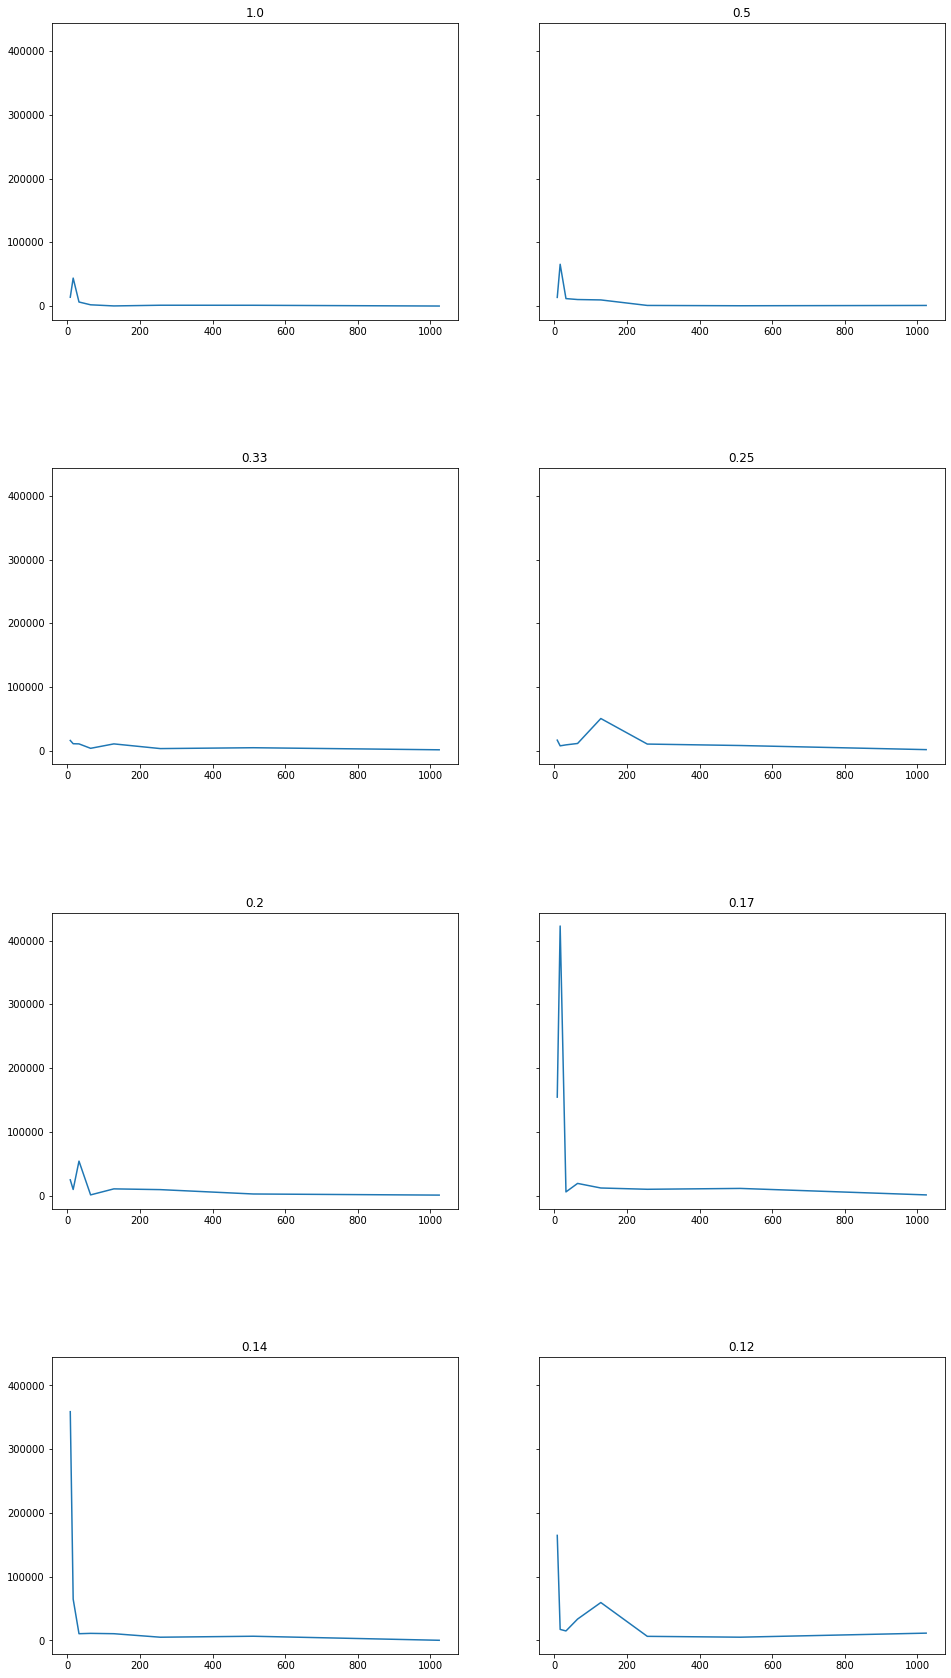

In [32]:
# plot initialization
fig, axs = plt.subplots(4, 2, sharey = True, figsize = (16,30))
fig.subplots_adjust(hspace = 0.5)

# epsilon values that we are going to examine
eps = [1 / i for i in range (1,9)]
# list of the sample sizes that we are going to take
sample_size = [2 ** i for i in range (3,11)]

# loop through the samples list
for e in range(0,8):
    ax = axs.flat[e]
    ax.set_title(round(eps[e],2))
    # list of the error rate that will occur
    error = []
    for i in sample_size:
        sample_df = df.sample(i)
        # compute mean calue with and without dp
        mean_wo_dp = np.mean(sample_df['Average Total Payments'])
        mean_with_dp = dp.tools.mean(sample_df['Average Total Payments'].tolist(), bounds = total_payment_range, epsilon = eps[e])
        # calculate the error produced by those measurements
        error.append(abs(mean_with_dp - mean_wo_dp))
    # each time plot the varience of the absolute error, as we are enlargening the dataset
    ax.plot(sample_size, error)
    
plt.show()

Facts gathered from the above analysis:
 - The smaller the epsilon gets, the bigger the error in case of small datasets
 - Error stabilizes near 0 as the size of the dataset gets $\leq 800 $

__After the analysis for the mean value query, we come to the conclusion that the value computed using DP, is not very far away from the real one, especially if we are dealing with a rather large dataset. Thus, despite of the tradeoff between privacy and accuracy, we can safely say that DP accomplishes its promise when applying a mean value query to a dataset__

### Variance

Next up, we're going to showcase how the `var` query is used. It is very simillar to the `mean`, as well as the numpy `var`.

We are going to try a more complicated query. Let's say we want to find the variance of the surgeries performed in Stanford Hospital 

In [36]:
var = dp.tools.var(df.loc[(df['Hospital name'] == 'STANFORD HOSPITAL')]['Average Medicare Payments'].tolist(), bounds = medicare_payment_range)
print (var)

1305000227.2443452


### Sum

A not so important query in our dataset, but essential in the real world is `sum`. Let's see how DP's additional noise effects the query.

We want to find the sum of all the surgery payments that were made in the state of California. Let's see what we get with, and without DP

In [44]:
sum_wo_dp = np.sum(df.loc[(df['Hospital state code'] == 'CA')]['Average Total Payments'].tolist())
sum_with_dp = dp.tools.sum(df.loc[(df['Hospital state code'] == 'CA')]['Average Total Payments'].tolist(), bounds = total_payment_range)
print("Regular sum: {:.2f}. \nSum with DP: {:.2f}".format(sum_wo_dp, sum_with_dp))

Regular sum: 262754253.11. 
Sum with DP: 262833214.15


There is a slight difference, but the error is rather small, if we consider that we are talking about hundreds of millions of dollars

## Histograms